## Here I will try to build a machine learning model with some feature engineering.

In [1]:
# coding: utf-8
# !/usr/bin/env python3
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import datetime
import holidays
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, HourLocator
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.externals import joblib

c:\users\ripunjoy gohain\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# getting the already cleaned data, if not available run through first exploration file (only getting the global active power column)
df = pd.read_csv("./data/cleaned_household_power_consumption.csv", infer_datetime_format=True, parse_dates=["local_time"],
                index_col=["local_time"], usecols=[0,1], dtype=np.float32)
# sampling to hourly records
df = df.resample("H").sum()

In [3]:
df.head()

,global_active_power
local_time,
2006-12-16 17:00:00,152.024002
2006-12-16 18:00:00,217.932007
2006-12-16 19:00:00,204.013992
2006-12-16 20:00:00,196.113998
2006-12-16 21:00:00,183.388000


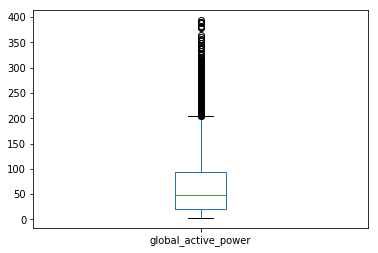

In [4]:
df.global_active_power.plot(kind="box");

### Model Strategy
1. Just for the sake of comparision, this model will also be on hourly data. Though minutely also will be easily trained in my CPU unlike Deep Learning models.
2. I will build a Gradient Boosting Regression Tree model (Can try with other regression models, just for trying to prove my concept will try it with GBRT.
3. I will manually engineer some feature from the time and active power (Will keep in mind that while giving prediction in real time I need these features in my hand). So, not going to create features which might help in better performance of while exploring but will make no sense in prediction time in production.
4. Will use min max scalar. Tree based models are suppose to be robust with outliers (from above box plot). I will go ahead with without removing the outliers, in later models I can try using some strategy like clipping or exploring and trying to create clusters out of it and supplying the cluster value as input.
5. To maintain the same structure, will use last 96 data points in test set, 30 days hours as evaluate (not 32 days like before, as it has no dependency like sequence models) and remaining as train set. Will train the model with cross validation. Give prediction for last 48, compare 30 days hourly (for 48 hours rmse like before) as well as overall rmse.

In [5]:
# like before removing this two points
df = df[~df.index.isin(["2006-12-16 17:00:00", "2010-11-26 21:00:00"])]

In [6]:
print("Data Range: ", df.index.min(), " to ", df.index.max())

Data Range:  2006-12-16 18:00:00  to  2010-11-26 20:00:00


### Feature Engineering:
1. There can be redundant feature, I am not going to analyse for that to begin with
2. If data is cyclic (like hours, days, months etc. eg: 23 and 0 hours are close to each other). Converting it to cyclic by using sine and cosine will help. Many of the cases any one of sine and cosine helps. I am just letting the Tree model to decicde which one to pick.

In [7]:
# Intuition is there should be a pattern with respect to time
total_hours = 24
max_days = 31
total_months = 12
total_weekdays = 7
# Sine cosine of hours: expecting that hour has a trend
df["cos_hour"] = np.cos((df.index.hour + 1) * (2 * np.pi / total_hours))
df["sin_hour"] = np.sin((df.index.hour + 1) * (2 * np.pi / total_hours))
# Expecting that month day has a trend
df["cos_day"] = np.cos((df.index.day) * (2 * np.pi / max_days))
df["sin_day"] = np.sin((df.index.day) * (2 * np.pi / max_days))
# Expecting weekday has a trend
df["cos_weekday"] = np.cos((df.index.weekday + 1) * (2 * np.pi / total_weekdays))
df["cos_weekday"] = np.sin((df.index.weekday + 1) * (2 * np.pi / total_weekdays))
# Categorical: keeping it in single column instead of making dummy, there are only 2 categories (can make dummy also)
df["isWeekend"] = (df.index.weekday < 5).astype(int)
# Expecting month wise there is a trend
df["cos_month"] = np.cos((df.index.day) * (2 * np.pi / total_months))
df["sin_month"] = np.sin((df.index.day) * (2 * np.pi / total_months))
# Creating dummy variables for quarter
df_q = pd.get_dummies(df.index.quarter, prefix="Q")
df_q["local_time"] = df.index
df_q.set_index("local_time", inplace=True)
df = df.merge(df_q, how="left", left_index=True, right_index=True)
del df_q

# Adding holidays, expecting that in holidays, power consumption will be high
# Our data is from Paris, France
france_holiday = holidays.France()
isHoliday = []
dates = []
df_dates = pd.date_range(df.index.min().strftime("%Y-%m-%d"), df.index.max().strftime("%Y-%m-%d"), freq="D")
for d in df_dates:
    day = d.strftime("%Y-%m-%d")
    dates.append(day)
    holiday = france_holiday.get(day)
    if holiday == None:
        # if not holiday
        holiday = 0
    else:
        # if holiday
        holiday = 1
    isHoliday.append(holiday)
holiday_df = pd.DataFrame({"date_time": dates, "isHoliday": isHoliday})

# merge this with df
df["date_time"] = df.index.strftime("%Y-%m-%d")
# while merging, original index is going away, so keeping it as a column
df.reset_index(inplace=True)
df = df.merge(holiday_df, how="left", on="date_time")
df.set_index("local_time", inplace=True)
df.drop(columns=["date_time"], inplace=True)

In [8]:
df.head()

,global_active_power,cos_hour,sin_hour,cos_day,sin_day,cos_weekday,isWeekend,cos_month,sin_month,Q_1,Q_2,Q_3,Q_4,isHoliday
local_time,,,,,,,,,,,,,,
2006-12-16 18:00:00,217.932007,0.258819,-0.965926,-0.994869,-0.101168,-0.781831,0,-0.5,0.866025,0,0,0,1,0
2006-12-16 19:00:00,204.013992,0.500000,-0.866025,-0.994869,-0.101168,-0.781831,0,-0.5,0.866025,0,0,0,1,0
2006-12-16 20:00:00,196.113998,0.707107,-0.707107,-0.994869,-0.101168,-0.781831,0,-0.5,0.866025,0,0,0,1,0
2006-12-16 21:00:00,183.388000,0.866025,-0.500000,-0.994869,-0.101168,-0.781831,0,-0.5,0.866025,0,0,0,1,0
2006-12-16 22:00:00,132.007996,0.965926,-0.258819,-0.994869,-0.101168,-0.781831,0,-0.5,0.866025,0,0,0,1,0


### Note: Now sine cosine ranges from -1 to 1, we will use min max scalar to change this scale to 0-1

In [9]:
# Previous 7 days power at the exact same hour
df_power = pd.DataFrame()
total_hours = 24
for i in range(1, 8):
    feature_column = "global_active_power_prev" + "_" + str(i)
    df_power.loc[:, feature_column] = df.loc[:, "global_active_power"].shift(int(total_hours * i))

In [10]:
df_power.head(3)

,global_active_power_prev_1,global_active_power_prev_2,global_active_power_prev_3,global_active_power_prev_4,global_active_power_prev_5,global_active_power_prev_6,global_active_power_prev_7
local_time,,,,,,,
2006-12-16 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-16 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-16 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Because firt few days don't have previous days data, we will drop those days
df_power["local_time"] = df.index
print("Before dropping: ", df_power.shape)
df_power.dropna(inplace=True)
print("After dropping: ", df_power.shape)
df_power.set_index("local_time", inplace=True)

Before dropping:  (34587, 8)
After dropping:  (34419, 8)


In [12]:
# Now we will take mean of few days
df_power["global_active_power_prev_mean_1_3"] = (df_power.global_active_power_prev_1 + df_power.global_active_power_prev_2 
                                                 + df_power.global_active_power_prev_3) / 3
df_power["global_active_power_prev_mean_1_5"] = (df_power.global_active_power_prev_1 + df_power.global_active_power_prev_2 
                                                 + df_power.global_active_power_prev_3 + df_power.global_active_power_prev_4 
                                                 + df_power.global_active_power_prev_5) / 5
df_power["global_active_power_prev_mean_1_7"] = (df_power.global_active_power_prev_1 + df_power.global_active_power_prev_2 
                                                 + df_power.global_active_power_prev_3 + df_power.global_active_power_prev_4 
                                                 + df_power.global_active_power_prev_5 + df_power.global_active_power_prev_6 
                                                 + df_power.global_active_power_prev_7) / 7
# will only use 4 of these
df_power = df_power[["global_active_power_prev_1" ,"global_active_power_prev_mean_1_3", "global_active_power_prev_mean_1_5", "global_active_power_prev_mean_1_7"]]

In [13]:
df_power.head()

,global_active_power_prev_1,global_active_power_prev_mean_1_3,global_active_power_prev_mean_1_5,global_active_power_prev_mean_1_7
local_time,,,,
2006-12-23 18:00:00,161.218002,159.341995,150.891998,170.602570
2006-12-23 19:00:00,236.289993,187.678665,166.086395,172.707153
2006-12-23 20:00:00,212.164001,190.978012,186.480011,190.029160
2006-12-23 21:00:00,272.920013,183.539993,153.475204,161.887131
2006-12-23 22:00:00,183.904007,128.085999,106.357201,107.839149


In [14]:
df = df_power.merge(df, how="left", left_index=True, right_index=True)
del df_power
print(df.shape)
df.head()

(34419, 18)


,global_active_power_prev_1,global_active_power_prev_mean_1_3,global_active_power_prev_mean_1_5,global_active_power_prev_mean_1_7,global_active_power,cos_hour,sin_hour,cos_day,sin_day,cos_weekday,isWeekend,cos_month,sin_month,Q_1,Q_2,Q_3,Q_4,isHoliday
local_time,,,,,,,,,,,,,,,,,,
2006-12-23 18:00:00,161.218002,159.341995,150.891998,170.602570,232.763992,0.258819,-0.965926,-0.050649,-0.998717,-0.781831,0,0.866025,-0.5,0,0,0,1,0
2006-12-23 19:00:00,236.289993,187.678665,166.086395,172.707153,247.069992,0.500000,-0.866025,-0.050649,-0.998717,-0.781831,0,0.866025,-0.5,0,0,0,1,0
2006-12-23 20:00:00,212.164001,190.978012,186.480011,190.029160,250.884003,0.707107,-0.707107,-0.050649,-0.998717,-0.781831,0,0.866025,-0.5,0,0,0,1,0
2006-12-23 21:00:00,272.920013,183.539993,153.475204,161.887131,197.306000,0.866025,-0.500000,-0.050649,-0.998717,-0.781831,0,0.866025,-0.5,0,0,0,1,0
2006-12-23 22:00:00,183.904007,128.085999,106.357201,107.839149,259.675995,0.965926,-0.258819,-0.050649,-0.998717,-0.781831,0,0.866025,-0.5,0,0,0,1,0


## Here we can try to implement ways to select features, but for simplicity leaving that part

In [15]:
# Split the 3 sets of data
test_start_time = df.index.max() - datetime.timedelta(hours=96-1)
eval_start_time = test_start_time - datetime.timedelta(days=30)
train = df[df.index < eval_start_time]
evaluate = df[(df.index >= eval_start_time) & (df.index < test_start_time)]
test = df[df.index >= test_start_time]
print("Training data shape: ", train.shape)
print("Evaluation data shape: ", evaluate.shape, " & expected rows is: ", 30*24)
print("Test data shape: ", test.shape, " & expected rows is: ", 4*24)

Training data shape:  (33603, 18)
Evaluation data shape:  (720, 18)  & expected rows is:  720
Test data shape:  (96, 18)  & expected rows is:  96


### Getting input X and output y

In [16]:
del df
list(train.columns.values)

['global_active_power_prev_1',
 'global_active_power_prev_mean_1_3',
 'global_active_power_prev_mean_1_5',
 'global_active_power_prev_mean_1_7',
 'global_active_power',
 'cos_hour',
 'sin_hour',
 'cos_day',
 'sin_day',
 'cos_weekday',
 'isWeekend',
 'cos_month',
 'sin_month',
 'Q_1',
 'Q_2',
 'Q_3',
 'Q_4',
 'isHoliday']

In [17]:
features = ["global_active_power_prev_1", "global_active_power_prev_mean_1_3", "global_active_power_prev_mean_1_5", "cos_hour", 
            "sin_hour", "cos_day", "sin_day", "cos_weekday", "isWeekend", "cos_month", "sin_month", "Q_1", "Q_2", "Q_3", "Q_4", 
            "isHoliday"]
label = "global_active_power"

In [18]:
def get_feature_labels(data_frame, features, label=None):
    if label is not None:
        # Labels are the values we want to predict
        labels = np.array(data_frame[label])
    else:
        # help in getting prediction data
        labels = None
    features_data = np.array(data_frame[features])
    return features_data, labels

In [19]:
X_train, y_train = get_feature_labels(data_frame=train, features=features, label=label)
X_eval, y_eval = get_feature_labels(data_frame=evaluate, features=features, label=label)
X_test, y_test = get_feature_labels(data_frame=test, features=features, label=label)
print("Train X shape: ", X_train.shape)
print("Train y shape: ", y_train.shape)
print("Evaluation X shape: ", X_eval.shape)
print("Evaluation y shape: ", y_eval.shape)
print("Test X shape: ", X_test.shape)
print("Test y shape: ", y_test.shape)

Train X shape:  (33603, 16)
Train y shape:  (33603,)
Evaluation X shape:  (720, 16)
Evaluation y shape:  (720,)
Test X shape:  (96, 16)
Test y shape:  (96,)


### Pipeline & Scaling target y

In [20]:
# scaling Y also, as X have lagged values of y
# for input X I will define the scalar in pipeline, for y_train I will be defining scalar separately
y_scalar = MinMaxScaler()
# here reshaped because scalar needs a 2D array, and again flattened because model needs an 1D array
y_train_scaled = y_scalar.fit_transform(y_train.reshape(-1,1)).flatten()
print("Verifying y_train shape: ", y_train_scaled.shape)

Verifying y_train shape:  (33603,)


In [21]:
# Saving this object for later use
joblib.dump(y_scalar, "./hourly_models/model_3/y_scalar.pkl")

['./hourly_models/model_3/y_scalar.pkl']

In [22]:
# seeding the values
seed = 101
np.random.seed(seed)
# define the estimator
gbrt = GradientBoostingRegressor(random_state=seed)
# defining pipeline
gbrt_pipeline = Pipeline([("preProcess", MinMaxScaler()), ("gbrt", gbrt)])

# define parameters for tuning: later if model doesn't perform well, will search for other spec
# It's not a pipeline, no need to write prefix "gbrt__"
parameters = {
        "gbrt__learning_rate": [0.05, 0.01, 0.005],
        "gbrt__max_depth": [3, 5, 9],
        "gbrt__subsample": [0.8, 0.9],
        "gbrt__n_estimators": [50, 80],
        "gbrt__min_samples_leaf": [30, 50],
        "gbrt__max_features": ["log2", "sqrt"]
    }

In [23]:
# Defining GridSearch with Cross Validation 5
# We can also try RandomGridSearch first to find out a approximate region and then grid search in the close region
# Refit True tries to rebuild the model with whole dataset using best estimator
gbm_cv = GridSearchCV(estimator=gbrt_pipeline,
                      param_grid=parameters,
                      cv=5,
                      refit=True,
                      scoring=make_scorer(mean_squared_error),
                      verbose=2)

### Train the model

In [24]:
# fit network
start = datetime.datetime.now()
gbm_cv.fit(X=X_train, y=y_train_scaled)
end = datetime.datetime.now()
print("Model training started at: ", start, " & ended at: ", end)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] gbrt__learning_rate=0.05, gbrt__max_depth=3, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.8 
[CV]  gbrt__learning_rate=0.05, gbrt__max_depth=3, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.8, total=   0.4s
[CV] gbrt__learning_rate=0.05, gbrt__max_depth=3, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  gbrt__learning_rate=0.05, gbrt__max_depth=3, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.8, total=   0.4s
[CV] gbrt__learning_rate=0.05, gbrt__max_depth=3, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.8 
[CV]  gbrt__learning_rate=0.05, gbrt__max_depth=3, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.8, total=   0.4s
[CV] gbrt__learning_rate=0.05, gbrt__max_depth=3, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.8 
[CV]  gbrt__learning_rate=0.05, gbrt__max_depth=3, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.8, total=   0.4s
[CV] gbrt__learning_rate=0.05, gbrt__max_depth=3, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.8 
[CV]  gbrt__learning_rate=0.05, gbrt__max_depth=3, gbrt__max_features=log2, gbr

[CV]  gbrt__learning_rate=0.05, gbrt__max_depth=3, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=50, gbrt__subsample=0.9, total=   0.4s
[CV] gbrt__learning_rate=0.05, gbrt__max_depth=3, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=50, gbrt__subsample=0.9 
[CV]  gbrt__learning_rate=0.05, gbrt__max_depth=3, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=50, gbrt__subsample=0.9, total=   0.4s
[CV] gbrt__learning_rate=0.05, gbrt__max_depth=3, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.8 
[CV]  gbrt__learning_rate=0.05, gbrt__max_depth=3, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.8, total=   0.6s
[CV] gbrt__learning_rate=0.05, gbrt__max_depth=3, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.8 
[CV]  gbrt__learning_rate=0.05, gbrt__max_depth=3, gbrt__max_features=log2, gbr

[CV]  gbrt__learning_rate=0.05, gbrt__max_depth=3, gbrt__max_features=sqrt, gbrt__min_samples_leaf=30, gbrt__n_estimators=80, gbrt__subsample=0.9, total=   0.7s
[CV] gbrt__learning_rate=0.05, gbrt__max_depth=3, gbrt__max_features=sqrt, gbrt__min_samples_leaf=30, gbrt__n_estimators=80, gbrt__subsample=0.9 
[CV]  gbrt__learning_rate=0.05, gbrt__max_depth=3, gbrt__max_features=sqrt, gbrt__min_samples_leaf=30, gbrt__n_estimators=80, gbrt__subsample=0.9, total=   0.6s
[CV] gbrt__learning_rate=0.05, gbrt__max_depth=3, gbrt__max_features=sqrt, gbrt__min_samples_leaf=30, gbrt__n_estimators=80, gbrt__subsample=0.9 
[CV]  gbrt__learning_rate=0.05, gbrt__max_depth=3, gbrt__max_features=sqrt, gbrt__min_samples_leaf=30, gbrt__n_estimators=80, gbrt__subsample=0.9, total=   0.6s
[CV] gbrt__learning_rate=0.05, gbrt__max_depth=3, gbrt__max_features=sqrt, gbrt__min_samples_leaf=30, gbrt__n_estimators=80, gbrt__subsample=0.9 
[CV]  gbrt__learning_rate=0.05, gbrt__max_depth=3, gbrt__max_features=sqrt, gbr

[CV]  gbrt__learning_rate=0.05, gbrt__max_depth=5, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.8, total=   0.7s
[CV] gbrt__learning_rate=0.05, gbrt__max_depth=5, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.8 
[CV]  gbrt__learning_rate=0.05, gbrt__max_depth=5, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.8, total=   0.7s
[CV] gbrt__learning_rate=0.05, gbrt__max_depth=5, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.8 
[CV]  gbrt__learning_rate=0.05, gbrt__max_depth=5, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.8, total=   0.7s
[CV] gbrt__learning_rate=0.05, gbrt__max_depth=5, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.9 
[CV]  gbrt__learning_rate=0.05, gbrt__max_depth=5, gbrt__max_features=log2, gbr

[CV]  gbrt__learning_rate=0.05, gbrt__max_depth=5, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=50, gbrt__subsample=0.9, total=   0.7s
[CV] gbrt__learning_rate=0.05, gbrt__max_depth=5, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.8 
[CV]  gbrt__learning_rate=0.05, gbrt__max_depth=5, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.8, total=   1.1s
[CV] gbrt__learning_rate=0.05, gbrt__max_depth=5, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.8 
[CV]  gbrt__learning_rate=0.05, gbrt__max_depth=5, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.8, total=   1.1s
[CV] gbrt__learning_rate=0.05, gbrt__max_depth=5, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.8 
[CV]  gbrt__learning_rate=0.05, gbrt__max_depth=5, gbrt__max_features=log2, gbr

[CV]  gbrt__learning_rate=0.05, gbrt__max_depth=5, gbrt__max_features=sqrt, gbrt__min_samples_leaf=30, gbrt__n_estimators=80, gbrt__subsample=0.9, total=   1.1s
[CV] gbrt__learning_rate=0.05, gbrt__max_depth=5, gbrt__max_features=sqrt, gbrt__min_samples_leaf=30, gbrt__n_estimators=80, gbrt__subsample=0.9 
[CV]  gbrt__learning_rate=0.05, gbrt__max_depth=5, gbrt__max_features=sqrt, gbrt__min_samples_leaf=30, gbrt__n_estimators=80, gbrt__subsample=0.9, total=   1.1s
[CV] gbrt__learning_rate=0.05, gbrt__max_depth=5, gbrt__max_features=sqrt, gbrt__min_samples_leaf=30, gbrt__n_estimators=80, gbrt__subsample=0.9 
[CV]  gbrt__learning_rate=0.05, gbrt__max_depth=5, gbrt__max_features=sqrt, gbrt__min_samples_leaf=30, gbrt__n_estimators=80, gbrt__subsample=0.9, total=   1.2s
[CV] gbrt__learning_rate=0.05, gbrt__max_depth=5, gbrt__max_features=sqrt, gbrt__min_samples_leaf=30, gbrt__n_estimators=80, gbrt__subsample=0.9 
[CV]  gbrt__learning_rate=0.05, gbrt__max_depth=5, gbrt__max_features=sqrt, gbr

[CV]  gbrt__learning_rate=0.05, gbrt__max_depth=9, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.8, total=   1.9s
[CV] gbrt__learning_rate=0.05, gbrt__max_depth=9, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.8 
[CV]  gbrt__learning_rate=0.05, gbrt__max_depth=9, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.8, total=   2.0s
[CV] gbrt__learning_rate=0.05, gbrt__max_depth=9, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.9 
[CV]  gbrt__learning_rate=0.05, gbrt__max_depth=9, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.9, total=   1.9s
[CV] gbrt__learning_rate=0.05, gbrt__max_depth=9, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.9 
[CV]  gbrt__learning_rate=0.05, gbrt__max_depth=9, gbrt__max_features=log2, gbr

[CV]  gbrt__learning_rate=0.05, gbrt__max_depth=9, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.8, total=   2.4s
[CV] gbrt__learning_rate=0.05, gbrt__max_depth=9, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.8 
[CV]  gbrt__learning_rate=0.05, gbrt__max_depth=9, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.8, total=   2.4s
[CV] gbrt__learning_rate=0.05, gbrt__max_depth=9, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.8 
[CV]  gbrt__learning_rate=0.05, gbrt__max_depth=9, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.8, total=   2.3s
[CV] gbrt__learning_rate=0.05, gbrt__max_depth=9, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.8 
[CV]  gbrt__learning_rate=0.05, gbrt__max_depth=9, gbrt__max_features=log2, gbr

[CV]  gbrt__learning_rate=0.05, gbrt__max_depth=9, gbrt__max_features=sqrt, gbrt__min_samples_leaf=30, gbrt__n_estimators=80, gbrt__subsample=0.9, total=   2.7s
[CV] gbrt__learning_rate=0.05, gbrt__max_depth=9, gbrt__max_features=sqrt, gbrt__min_samples_leaf=30, gbrt__n_estimators=80, gbrt__subsample=0.9 
[CV]  gbrt__learning_rate=0.05, gbrt__max_depth=9, gbrt__max_features=sqrt, gbrt__min_samples_leaf=30, gbrt__n_estimators=80, gbrt__subsample=0.9, total=   2.7s
[CV] gbrt__learning_rate=0.05, gbrt__max_depth=9, gbrt__max_features=sqrt, gbrt__min_samples_leaf=30, gbrt__n_estimators=80, gbrt__subsample=0.9 
[CV]  gbrt__learning_rate=0.05, gbrt__max_depth=9, gbrt__max_features=sqrt, gbrt__min_samples_leaf=30, gbrt__n_estimators=80, gbrt__subsample=0.9, total=   2.7s
[CV] gbrt__learning_rate=0.05, gbrt__max_depth=9, gbrt__max_features=sqrt, gbrt__min_samples_leaf=50, gbrt__n_estimators=50, gbrt__subsample=0.8 
[CV]  gbrt__learning_rate=0.05, gbrt__max_depth=9, gbrt__max_features=sqrt, gbr

[CV]  gbrt__learning_rate=0.01, gbrt__max_depth=3, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.8, total=   0.4s
[CV] gbrt__learning_rate=0.01, gbrt__max_depth=3, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.9 
[CV]  gbrt__learning_rate=0.01, gbrt__max_depth=3, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.9, total=   0.4s
[CV] gbrt__learning_rate=0.01, gbrt__max_depth=3, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.9 
[CV]  gbrt__learning_rate=0.01, gbrt__max_depth=3, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.9, total=   0.4s
[CV] gbrt__learning_rate=0.01, gbrt__max_depth=3, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.9 
[CV]  gbrt__learning_rate=0.01, gbrt__max_depth=3, gbrt__max_features=log2, gbr

[CV]  gbrt__learning_rate=0.01, gbrt__max_depth=3, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.8, total=   0.6s
[CV] gbrt__learning_rate=0.01, gbrt__max_depth=3, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.8 
[CV]  gbrt__learning_rate=0.01, gbrt__max_depth=3, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.8, total=   0.6s
[CV] gbrt__learning_rate=0.01, gbrt__max_depth=3, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.8 
[CV]  gbrt__learning_rate=0.01, gbrt__max_depth=3, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.8, total=   0.6s
[CV] gbrt__learning_rate=0.01, gbrt__max_depth=3, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.8 
[CV]  gbrt__learning_rate=0.01, gbrt__max_depth=3, gbrt__max_features=log2, gbr

[CV]  gbrt__learning_rate=0.01, gbrt__max_depth=3, gbrt__max_features=sqrt, gbrt__min_samples_leaf=30, gbrt__n_estimators=80, gbrt__subsample=0.9, total=   0.6s
[CV] gbrt__learning_rate=0.01, gbrt__max_depth=3, gbrt__max_features=sqrt, gbrt__min_samples_leaf=30, gbrt__n_estimators=80, gbrt__subsample=0.9 
[CV]  gbrt__learning_rate=0.01, gbrt__max_depth=3, gbrt__max_features=sqrt, gbrt__min_samples_leaf=30, gbrt__n_estimators=80, gbrt__subsample=0.9, total=   0.6s
[CV] gbrt__learning_rate=0.01, gbrt__max_depth=3, gbrt__max_features=sqrt, gbrt__min_samples_leaf=50, gbrt__n_estimators=50, gbrt__subsample=0.8 
[CV]  gbrt__learning_rate=0.01, gbrt__max_depth=3, gbrt__max_features=sqrt, gbrt__min_samples_leaf=50, gbrt__n_estimators=50, gbrt__subsample=0.8, total=   0.4s
[CV] gbrt__learning_rate=0.01, gbrt__max_depth=3, gbrt__max_features=sqrt, gbrt__min_samples_leaf=50, gbrt__n_estimators=50, gbrt__subsample=0.8 
[CV]  gbrt__learning_rate=0.01, gbrt__max_depth=3, gbrt__max_features=sqrt, gbr

[CV]  gbrt__learning_rate=0.01, gbrt__max_depth=5, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.9, total=   0.7s
[CV] gbrt__learning_rate=0.01, gbrt__max_depth=5, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.9 
[CV]  gbrt__learning_rate=0.01, gbrt__max_depth=5, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.9, total=   0.7s
[CV] gbrt__learning_rate=0.01, gbrt__max_depth=5, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.9 
[CV]  gbrt__learning_rate=0.01, gbrt__max_depth=5, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.9, total=   0.7s
[CV] gbrt__learning_rate=0.01, gbrt__max_depth=5, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.9 
[CV]  gbrt__learning_rate=0.01, gbrt__max_depth=5, gbrt__max_features=log2, gbr

[CV]  gbrt__learning_rate=0.01, gbrt__max_depth=5, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.8, total=   1.1s
[CV] gbrt__learning_rate=0.01, gbrt__max_depth=5, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.8 
[CV]  gbrt__learning_rate=0.01, gbrt__max_depth=5, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.8, total=   1.1s
[CV] gbrt__learning_rate=0.01, gbrt__max_depth=5, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.8 
[CV]  gbrt__learning_rate=0.01, gbrt__max_depth=5, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.8, total=   1.1s
[CV] gbrt__learning_rate=0.01, gbrt__max_depth=5, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.9 
[CV]  gbrt__learning_rate=0.01, gbrt__max_depth=5, gbrt__max_features=log2, gbr

[CV]  gbrt__learning_rate=0.01, gbrt__max_depth=5, gbrt__max_features=sqrt, gbrt__min_samples_leaf=30, gbrt__n_estimators=80, gbrt__subsample=0.9, total=   1.1s
[CV] gbrt__learning_rate=0.01, gbrt__max_depth=5, gbrt__max_features=sqrt, gbrt__min_samples_leaf=50, gbrt__n_estimators=50, gbrt__subsample=0.8 
[CV]  gbrt__learning_rate=0.01, gbrt__max_depth=5, gbrt__max_features=sqrt, gbrt__min_samples_leaf=50, gbrt__n_estimators=50, gbrt__subsample=0.8, total=   0.7s
[CV] gbrt__learning_rate=0.01, gbrt__max_depth=5, gbrt__max_features=sqrt, gbrt__min_samples_leaf=50, gbrt__n_estimators=50, gbrt__subsample=0.8 
[CV]  gbrt__learning_rate=0.01, gbrt__max_depth=5, gbrt__max_features=sqrt, gbrt__min_samples_leaf=50, gbrt__n_estimators=50, gbrt__subsample=0.8, total=   0.7s
[CV] gbrt__learning_rate=0.01, gbrt__max_depth=5, gbrt__max_features=sqrt, gbrt__min_samples_leaf=50, gbrt__n_estimators=50, gbrt__subsample=0.8 
[CV]  gbrt__learning_rate=0.01, gbrt__max_depth=5, gbrt__max_features=sqrt, gbr

[CV]  gbrt__learning_rate=0.01, gbrt__max_depth=9, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.9, total=   1.9s
[CV] gbrt__learning_rate=0.01, gbrt__max_depth=9, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.9 
[CV]  gbrt__learning_rate=0.01, gbrt__max_depth=9, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.9, total=   1.9s
[CV] gbrt__learning_rate=0.01, gbrt__max_depth=9, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.9 
[CV]  gbrt__learning_rate=0.01, gbrt__max_depth=9, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.9, total=   2.0s
[CV] gbrt__learning_rate=0.01, gbrt__max_depth=9, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.9 
[CV]  gbrt__learning_rate=0.01, gbrt__max_depth=9, gbrt__max_features=log2, gbr

[CV]  gbrt__learning_rate=0.01, gbrt__max_depth=9, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.8, total=   2.6s
[CV] gbrt__learning_rate=0.01, gbrt__max_depth=9, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.8 
[CV]  gbrt__learning_rate=0.01, gbrt__max_depth=9, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.8, total=   2.6s
[CV] gbrt__learning_rate=0.01, gbrt__max_depth=9, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.9 
[CV]  gbrt__learning_rate=0.01, gbrt__max_depth=9, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.9, total=   2.8s
[CV] gbrt__learning_rate=0.01, gbrt__max_depth=9, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.9 
[CV]  gbrt__learning_rate=0.01, gbrt__max_depth=9, gbrt__max_features=log2, gbr

[CV]  gbrt__learning_rate=0.01, gbrt__max_depth=9, gbrt__max_features=sqrt, gbrt__min_samples_leaf=50, gbrt__n_estimators=50, gbrt__subsample=0.8, total=   1.7s
[CV] gbrt__learning_rate=0.01, gbrt__max_depth=9, gbrt__max_features=sqrt, gbrt__min_samples_leaf=50, gbrt__n_estimators=50, gbrt__subsample=0.8 
[CV]  gbrt__learning_rate=0.01, gbrt__max_depth=9, gbrt__max_features=sqrt, gbrt__min_samples_leaf=50, gbrt__n_estimators=50, gbrt__subsample=0.8, total=   1.7s
[CV] gbrt__learning_rate=0.01, gbrt__max_depth=9, gbrt__max_features=sqrt, gbrt__min_samples_leaf=50, gbrt__n_estimators=50, gbrt__subsample=0.8 
[CV]  gbrt__learning_rate=0.01, gbrt__max_depth=9, gbrt__max_features=sqrt, gbrt__min_samples_leaf=50, gbrt__n_estimators=50, gbrt__subsample=0.8, total=   1.8s
[CV] gbrt__learning_rate=0.01, gbrt__max_depth=9, gbrt__max_features=sqrt, gbrt__min_samples_leaf=50, gbrt__n_estimators=50, gbrt__subsample=0.8 
[CV]  gbrt__learning_rate=0.01, gbrt__max_depth=9, gbrt__max_features=sqrt, gbr

[CV]  gbrt__learning_rate=0.005, gbrt__max_depth=3, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.9, total=   0.4s
[CV] gbrt__learning_rate=0.005, gbrt__max_depth=3, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.9 
[CV]  gbrt__learning_rate=0.005, gbrt__max_depth=3, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.9, total=   0.4s
[CV] gbrt__learning_rate=0.005, gbrt__max_depth=3, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.9 
[CV]  gbrt__learning_rate=0.005, gbrt__max_depth=3, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.9, total=   0.4s
[CV] gbrt__learning_rate=0.005, gbrt__max_depth=3, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=80, gbrt__subsample=0.8 
[CV]  gbrt__learning_rate=0.005, gbrt__max_depth=3, gbrt__max_features=lo

[CV]  gbrt__learning_rate=0.005, gbrt__max_depth=3, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.8, total=   0.6s
[CV] gbrt__learning_rate=0.005, gbrt__max_depth=3, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.9 
[CV]  gbrt__learning_rate=0.005, gbrt__max_depth=3, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.9, total=   0.6s
[CV] gbrt__learning_rate=0.005, gbrt__max_depth=3, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.9 
[CV]  gbrt__learning_rate=0.005, gbrt__max_depth=3, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.9, total=   0.6s
[CV] gbrt__learning_rate=0.005, gbrt__max_depth=3, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.9 
[CV]  gbrt__learning_rate=0.005, gbrt__max_depth=3, gbrt__max_features=lo

[CV]  gbrt__learning_rate=0.005, gbrt__max_depth=3, gbrt__max_features=sqrt, gbrt__min_samples_leaf=50, gbrt__n_estimators=50, gbrt__subsample=0.8, total=   0.4s
[CV] gbrt__learning_rate=0.005, gbrt__max_depth=3, gbrt__max_features=sqrt, gbrt__min_samples_leaf=50, gbrt__n_estimators=50, gbrt__subsample=0.8 
[CV]  gbrt__learning_rate=0.005, gbrt__max_depth=3, gbrt__max_features=sqrt, gbrt__min_samples_leaf=50, gbrt__n_estimators=50, gbrt__subsample=0.8, total=   0.4s
[CV] gbrt__learning_rate=0.005, gbrt__max_depth=3, gbrt__max_features=sqrt, gbrt__min_samples_leaf=50, gbrt__n_estimators=50, gbrt__subsample=0.8 
[CV]  gbrt__learning_rate=0.005, gbrt__max_depth=3, gbrt__max_features=sqrt, gbrt__min_samples_leaf=50, gbrt__n_estimators=50, gbrt__subsample=0.8, total=   0.4s
[CV] gbrt__learning_rate=0.005, gbrt__max_depth=3, gbrt__max_features=sqrt, gbrt__min_samples_leaf=50, gbrt__n_estimators=50, gbrt__subsample=0.8 
[CV]  gbrt__learning_rate=0.005, gbrt__max_depth=3, gbrt__max_features=sq

[CV]  gbrt__learning_rate=0.005, gbrt__max_depth=5, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.9, total=   0.7s
[CV] gbrt__learning_rate=0.005, gbrt__max_depth=5, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.9 
[CV]  gbrt__learning_rate=0.005, gbrt__max_depth=5, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.9, total=   0.7s
[CV] gbrt__learning_rate=0.005, gbrt__max_depth=5, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=80, gbrt__subsample=0.8 
[CV]  gbrt__learning_rate=0.005, gbrt__max_depth=5, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=80, gbrt__subsample=0.8, total=   1.1s
[CV] gbrt__learning_rate=0.005, gbrt__max_depth=5, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=80, gbrt__subsample=0.8 
[CV]  gbrt__learning_rate=0.005, gbrt__max_depth=5, gbrt__max_features=lo

[CV]  gbrt__learning_rate=0.005, gbrt__max_depth=5, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.9, total=   1.1s
[CV] gbrt__learning_rate=0.005, gbrt__max_depth=5, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.9 
[CV]  gbrt__learning_rate=0.005, gbrt__max_depth=5, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.9, total=   1.1s
[CV] gbrt__learning_rate=0.005, gbrt__max_depth=5, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.9 
[CV]  gbrt__learning_rate=0.005, gbrt__max_depth=5, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.9, total=   1.1s
[CV] gbrt__learning_rate=0.005, gbrt__max_depth=5, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.9 
[CV]  gbrt__learning_rate=0.005, gbrt__max_depth=5, gbrt__max_features=lo

[CV]  gbrt__learning_rate=0.005, gbrt__max_depth=5, gbrt__max_features=sqrt, gbrt__min_samples_leaf=50, gbrt__n_estimators=50, gbrt__subsample=0.8, total=   0.7s
[CV] gbrt__learning_rate=0.005, gbrt__max_depth=5, gbrt__max_features=sqrt, gbrt__min_samples_leaf=50, gbrt__n_estimators=50, gbrt__subsample=0.8 
[CV]  gbrt__learning_rate=0.005, gbrt__max_depth=5, gbrt__max_features=sqrt, gbrt__min_samples_leaf=50, gbrt__n_estimators=50, gbrt__subsample=0.8, total=   0.7s
[CV] gbrt__learning_rate=0.005, gbrt__max_depth=5, gbrt__max_features=sqrt, gbrt__min_samples_leaf=50, gbrt__n_estimators=50, gbrt__subsample=0.8 
[CV]  gbrt__learning_rate=0.005, gbrt__max_depth=5, gbrt__max_features=sqrt, gbrt__min_samples_leaf=50, gbrt__n_estimators=50, gbrt__subsample=0.8, total=   0.7s
[CV] gbrt__learning_rate=0.005, gbrt__max_depth=5, gbrt__max_features=sqrt, gbrt__min_samples_leaf=50, gbrt__n_estimators=50, gbrt__subsample=0.9 
[CV]  gbrt__learning_rate=0.005, gbrt__max_depth=5, gbrt__max_features=sq

[CV]  gbrt__learning_rate=0.005, gbrt__max_depth=9, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=50, gbrt__subsample=0.9, total=   1.9s
[CV] gbrt__learning_rate=0.005, gbrt__max_depth=9, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=80, gbrt__subsample=0.8 
[CV]  gbrt__learning_rate=0.005, gbrt__max_depth=9, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=80, gbrt__subsample=0.8, total=   2.9s
[CV] gbrt__learning_rate=0.005, gbrt__max_depth=9, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=80, gbrt__subsample=0.8 
[CV]  gbrt__learning_rate=0.005, gbrt__max_depth=9, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=80, gbrt__subsample=0.8, total=   3.1s
[CV] gbrt__learning_rate=0.005, gbrt__max_depth=9, gbrt__max_features=log2, gbrt__min_samples_leaf=30, gbrt__n_estimators=80, gbrt__subsample=0.8 
[CV]  gbrt__learning_rate=0.005, gbrt__max_depth=9, gbrt__max_features=lo

[CV]  gbrt__learning_rate=0.005, gbrt__max_depth=9, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.9, total=   2.8s
[CV] gbrt__learning_rate=0.005, gbrt__max_depth=9, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.9 
[CV]  gbrt__learning_rate=0.005, gbrt__max_depth=9, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.9, total=   2.8s
[CV] gbrt__learning_rate=0.005, gbrt__max_depth=9, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.9 
[CV]  gbrt__learning_rate=0.005, gbrt__max_depth=9, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.9, total=   3.0s
[CV] gbrt__learning_rate=0.005, gbrt__max_depth=9, gbrt__max_features=log2, gbrt__min_samples_leaf=50, gbrt__n_estimators=80, gbrt__subsample=0.9 
[CV]  gbrt__learning_rate=0.005, gbrt__max_depth=9, gbrt__max_features=lo

[CV]  gbrt__learning_rate=0.005, gbrt__max_depth=9, gbrt__max_features=sqrt, gbrt__min_samples_leaf=50, gbrt__n_estimators=50, gbrt__subsample=0.8, total=   1.6s
[CV] gbrt__learning_rate=0.005, gbrt__max_depth=9, gbrt__max_features=sqrt, gbrt__min_samples_leaf=50, gbrt__n_estimators=50, gbrt__subsample=0.8 
[CV]  gbrt__learning_rate=0.005, gbrt__max_depth=9, gbrt__max_features=sqrt, gbrt__min_samples_leaf=50, gbrt__n_estimators=50, gbrt__subsample=0.8, total=   1.6s
[CV] gbrt__learning_rate=0.005, gbrt__max_depth=9, gbrt__max_features=sqrt, gbrt__min_samples_leaf=50, gbrt__n_estimators=50, gbrt__subsample=0.9 
[CV]  gbrt__learning_rate=0.005, gbrt__max_depth=9, gbrt__max_features=sqrt, gbrt__min_samples_leaf=50, gbrt__n_estimators=50, gbrt__subsample=0.9, total=   1.8s
[CV] gbrt__learning_rate=0.005, gbrt__max_depth=9, gbrt__max_features=sqrt, gbrt__min_samples_leaf=50, gbrt__n_estimators=50, gbrt__subsample=0.9 
[CV]  gbrt__learning_rate=0.005, gbrt__max_depth=9, gbrt__max_features=sq

[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed: 17.2min finished


Model training started at:  2019-10-07 14:50:20.159735  & ended at:  2019-10-07 15:07:34.516800


### It took around 17 minutes to search on define parameters, we can extend our search parameters.

In [25]:
# best parameters
gbm_cv.best_params_

{'gbrt__learning_rate': 0.005,
 'gbrt__max_depth': 3,
 'gbrt__max_features': 'log2',
 'gbrt__min_samples_leaf': 50,
 'gbrt__n_estimators': 50,
 'gbrt__subsample': 0.8}

In [26]:
# Saving the best model with pipeline
joblib.dump(gbm_cv.best_estimator_, "./hourly_models/model_3/gbrt_best_pipeline.pkl")

['./hourly_models/model_3/gbrt_best_pipeline.pkl']

In [29]:
print("Best parameters (CV score={:.3f}):".format(gbm_cv.best_score_))

Best parameters (CV score=0.017):


### Evaluating the model with evaluation data

In [30]:
best_model = joblib.load("./hourly_models/model_3/gbrt_best_pipeline.pkl")

In [31]:
evaluation = best_model.predict(X_eval)

In [32]:
evaluation.shape

(720,)

In [33]:
evaluation[0:10]

array([0.18238705, 0.16403976, 0.14346712, 0.14669966, 0.13412895,
       0.13446237, 0.1338648 , 0.1336356 , 0.1353392 , 0.14833836])

In [34]:
# we need to inverve transform the scale using y_scalar
evaluation = y_scalar.inverse_transform(evaluation.reshape(-1,1)).flatten()

In [35]:
evaluation[0:10]

array([77.87641577, 70.79084009, 62.84585018, 64.09423225, 59.23952505,
       59.36828891, 59.13751066, 59.04899799, 59.70691175, 64.7270856 ])

In [36]:
# We already have evaluate df to compare
evaluate["predictions"] = evaluation

In [37]:
evaluate.head()

,global_active_power_prev_1,global_active_power_prev_mean_1_3,global_active_power_prev_mean_1_5,global_active_power_prev_mean_1_7,global_active_power,cos_hour,sin_hour,cos_day,sin_day,cos_weekday,isWeekend,cos_month,sin_month,Q_1,Q_2,Q_3,Q_4,isHoliday,predictions
local_time,,,,,,,,,,,,,,,,,,,
2010-10-23 21:00:00,137.505997,153.561340,163.020416,138.052582,198.498001,0.866025,-5.000000e-01,-0.050649,-0.998717,-7.818315e-01,0,0.866025,-5.000000e-01,0,0,0,1,0,77.876416
2010-10-23 22:00:00,64.360001,94.383339,102.663597,84.571144,77.930000,0.965926,-2.588190e-01,-0.050649,-0.998717,-7.818315e-01,0,0.866025,-5.000000e-01,0,0,0,1,0,70.790840
2010-10-23 23:00:00,18.718000,37.132000,51.816002,50.047718,126.480003,1.000000,-2.449294e-16,-0.050649,-0.998717,-7.818315e-01,0,0.866025,-5.000000e-01,0,0,0,1,0,62.845850
2010-10-24 00:00:00,85.750000,48.006668,59.678795,50.357998,103.131996,0.965926,2.588190e-01,0.151428,-0.988468,-2.449294e-16,0,1.000000,-4.898587e-16,0,0,0,1,0,64.094232
2010-10-24 01:00:00,21.980000,33.247334,32.890404,29.638859,89.875999,0.866025,5.000000e-01,0.151428,-0.988468,-2.449294e-16,0,1.000000,-4.898587e-16,0,0,0,1,0,59.239525


In [38]:
evaluate = evaluate[["global_active_power", "predictions"]]

In [39]:
# Overall RMSE
overall_mse = mean_squared_error(evaluate.global_active_power, evaluate.predictions)
overall_rmse = np.sqrt(overall_mse)
print("Overall RMSE for 1 months evaluation period is: {:.2f}".format(overall_rmse))

Overall RMSE for 1 months evaluation period is: 48.17


### Give Predictions for last 2 days (48 hours)

In [41]:
prediction = best_model.predict(X_test)
# we need to inverve transform the scale using y_scalar
prediction = y_scalar.inverse_transform(prediction.reshape(-1,1)).flatten()
# we already have test df 
test["predictions"] = prediction

In [42]:
# need only last 48 hours prediction
test_last_48 = test.iloc[-48:]

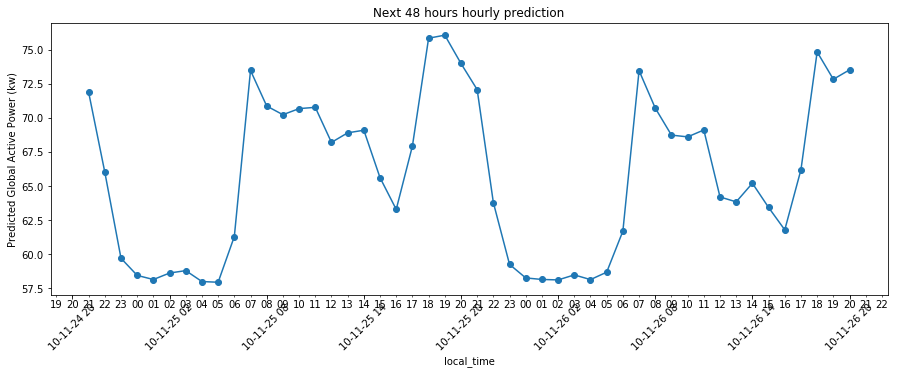

In [43]:
# Can share the visualtization also as a prediction results
fig, ax = plt.subplots(figsize=(15,5))
ax.plot("predictions", data=test_last_48, marker="o")
ax.set(xlabel="local_time", ylabel="Predicted Global Active Power (kw)",
       title="Next 48 hours hourly prediction")
ax.xaxis.set_major_formatter(DateFormatter("%y-%m-%d %H"))
ax.xaxis.set_minor_locator(HourLocator())
ax.xaxis.set_minor_formatter(DateFormatter("%H"))
plt.xticks(rotation=45);

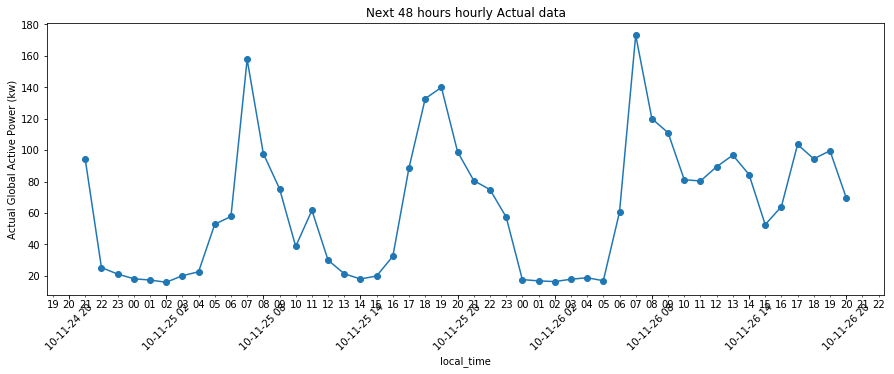

In [44]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot("global_active_power", data=test_last_48, marker="o")
ax.set(xlabel="local_time", ylabel="Actual Global Active Power (kw)",
       title="Next 48 hours hourly Actual data")
ax.xaxis.set_major_formatter(DateFormatter("%y-%m-%d %H"))
ax.xaxis.set_minor_locator(HourLocator())
ax.xaxis.set_minor_formatter(DateFormatter("%H"))
plt.xticks(rotation=45);

### Here if we see the actual and predicted side by side, it looks like model able to understand the trend. But if we look at Y-axis the scales are different

### Compare Actual vs Predicted

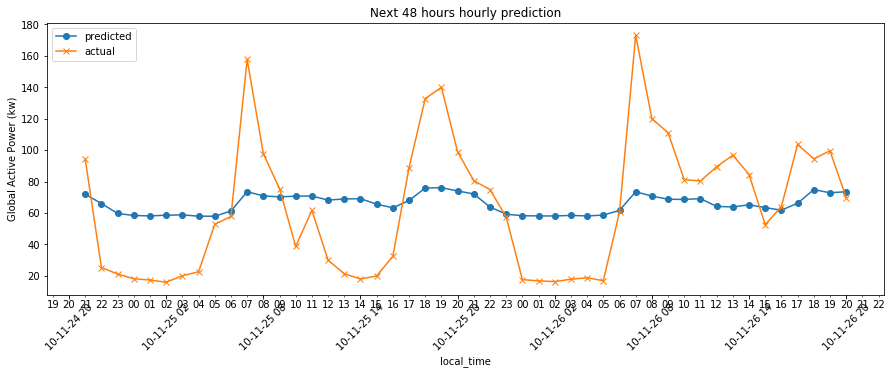

In [45]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot("predictions", data=test_last_48, marker="o")
ax.plot("global_active_power", data=test_last_48, marker="x")
ax.set(xlabel="local_time", ylabel="Global Active Power (kw)",
       title="Next 48 hours hourly prediction")
ax.xaxis.set_major_formatter(DateFormatter("%y-%m-%d %H"))
ax.xaxis.set_minor_locator(HourLocator())
ax.xaxis.set_minor_formatter(DateFormatter("%H"))
plt.legend(["predicted", "actual"], loc='upper left')
plt.xticks(rotation=45);

### Here it shows that, the model was unable to understand the peaks. Just hanging around in the mean values. With little understand about the patterns.
1. Machine Learning problems faces these kind of issues, there can be N-number of variable because of which power consumption is high or low. Like: Temperature of that day, at what time sun set and rises, some favourite movie show etc.
2. Here scaling is also an issue, many of a time tree kind of models understand without scaling the data itself.

# Trying with without scaling the data:
**Also changing the parameters search space a little bit**

In [52]:
# seeding the values
seed = 101
np.random.seed(seed)
# define the estimator
gbrt_unscaled = GradientBoostingRegressor(random_state=seed)

# define parameters for tuning: later if model doesn't perform well, will search for other spec
# It's not a pipeline, so no need to write prefix "gbrt__"
parameters_2 = {
        "learning_rate": [0.01, 0.005, 0.001],
        "max_depth": [5, 10, 15],
        "subsample": [0.8, 0.9],
        "n_estimators": [50, 80, 100],
        "min_samples_leaf": [30, 50],
        "max_features": ["log2", "sqrt"]
    }

# Defining GridSearch with Cross Validation 5
# We can also try RandomGridSearch first to find out a approximate region and then grid search in the close region
gbm_cv_unscaled = GridSearchCV(estimator=gbrt_unscaled,
                      param_grid=parameters_2,
                      cv=5,
                      scoring=make_scorer(mean_squared_error),
                      verbose=1)

In [53]:
y_train[0:10]

array([232.76399, 247.06999, 250.884  , 197.306  , 259.676  , 333.748  ,
       241.68   , 196.54199, 138.182  ,  96.406  ], dtype=float32)

In [54]:
# fit network
start = datetime.datetime.now()
gbm_cv_unscaled.fit(X=X_train, y=y_train)
end = datetime.datetime.now()
print("Model training started at: ", start, " & ended at: ", end)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed: 56.8min finished


Model training started at:  2019-10-07 16:11:49.884369  & ended at:  2019-10-07 17:08:39.542746


In [55]:
# Training will take time as we didn't scale the data, it took 56 minutes

In [56]:
# best parameters
gbm_cv_unscaled.best_params_

{'learning_rate': 0.001,
 'max_depth': 5,
 'max_features': 'log2',
 'min_samples_leaf': 50,
 'n_estimators': 50,
 'subsample': 0.8}

In [57]:
# Saving the best model with pipeline
joblib.dump(gbm_cv_unscaled.best_estimator_, "./hourly_models/model_3/gbrt_best_unscaled.pkl")

['./hourly_models/model_3/gbrt_best_unscaled.pkl']

In [58]:
print("Best parameters (CV score={:.3f}):".format(gbm_cv_unscaled.best_score_))

Best parameters (CV score=2797.942):


In [59]:
# Evaluating the model with evaluation data
evaluation = gbm_cv_unscaled.predict(X_eval)

In [60]:
# We already have evaluate df to compare
evaluate["predictions"] = evaluation
evaluate = evaluate[["global_active_power", "predictions"]]
# Overall RMSE
overall_mse = mean_squared_error(evaluate.global_active_power, evaluate.predictions)
overall_rmse = np.sqrt(overall_mse)
print("Overall RMSE for 1 months evaluation period is: {:.2f}".format(overall_rmse))

Overall RMSE for 1 months evaluation period is: 49.87


### Give Predictions for last 2 days (48 hours)

In [61]:
prediction = gbm_cv_unscaled.predict(X_test)
# we already have test df 
test["predictions"] = prediction
# need only last 48 hours prediction
test_last_48 = test.iloc[-48:]

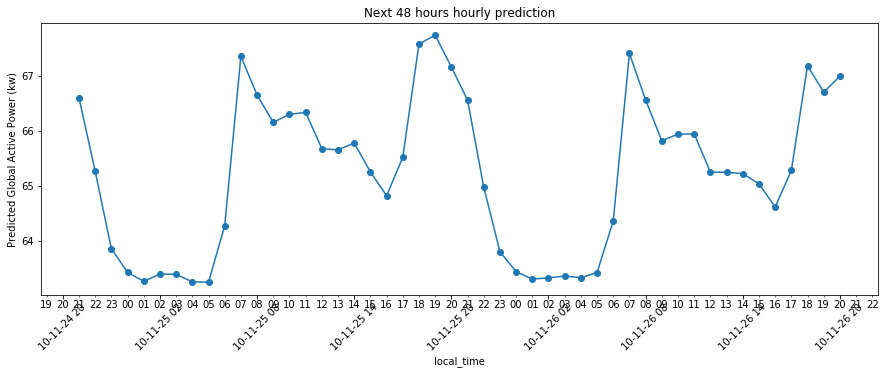

In [62]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot("predictions", data=test_last_48, marker="o")
ax.set(xlabel="local_time", ylabel="Predicted Global Active Power (kw)",
       title="Next 48 hours hourly prediction")
ax.xaxis.set_major_formatter(DateFormatter("%y-%m-%d %H"))
ax.xaxis.set_minor_locator(HourLocator())
ax.xaxis.set_minor_formatter(DateFormatter("%H"))
plt.xticks(rotation=45);

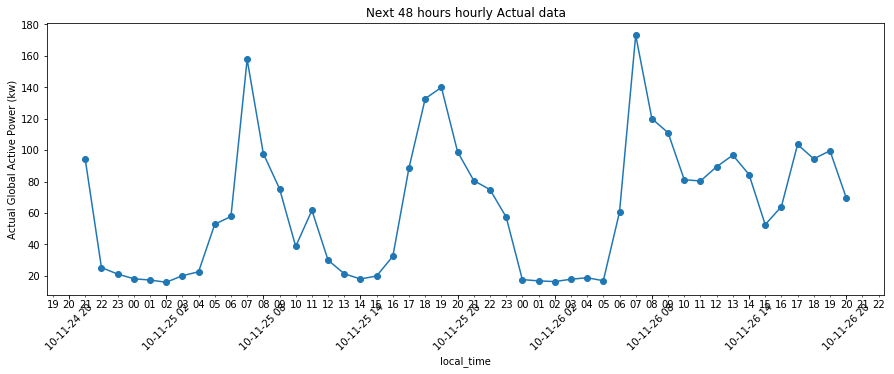

In [63]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot("global_active_power", data=test_last_48, marker="o")
ax.set(xlabel="local_time", ylabel="Actual Global Active Power (kw)",
       title="Next 48 hours hourly Actual data")
ax.xaxis.set_major_formatter(DateFormatter("%y-%m-%d %H"))
ax.xaxis.set_minor_locator(HourLocator())
ax.xaxis.set_minor_formatter(DateFormatter("%H"))
plt.xticks(rotation=45);

### Again same issues, model able to figure out the pattern but not the magitude

### Compare Actual vs Predicted

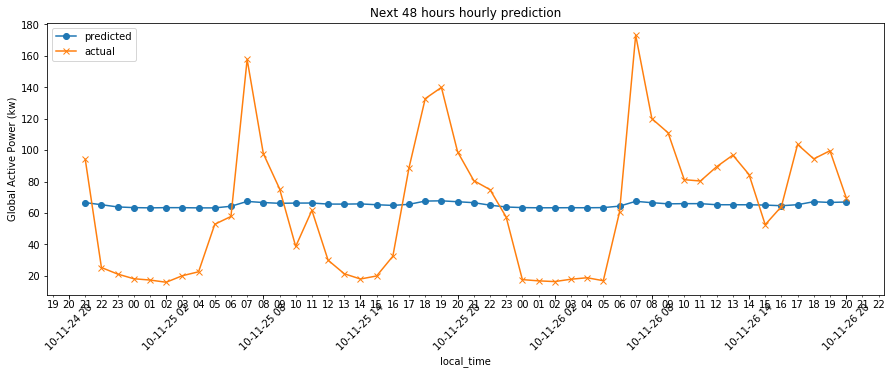

In [64]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot("predictions", data=test_last_48, marker="o")
ax.plot("global_active_power", data=test_last_48, marker="x")
ax.set(xlabel="local_time", ylabel="Global Active Power (kw)",
       title="Next 48 hours hourly prediction")
ax.xaxis.set_major_formatter(DateFormatter("%y-%m-%d %H"))
ax.xaxis.set_minor_locator(HourLocator())
ax.xaxis.set_minor_formatter(DateFormatter("%H"))
plt.legend(["predicted", "actual"], loc='upper left')
plt.xticks(rotation=45);

In [65]:
train_prediction = gbm_cv_unscaled.predict(X_train)

In [66]:
train["prediction"] = train_prediction

In [67]:
train.global_active_power.describe()

count    33603.000000
mean        65.046333
std         53.615524
min          7.440000
25%         20.465000
50%         47.554001
75%         94.187000
max        393.631989
Name: global_active_power, dtype: float64

In [68]:
train.prediction.describe()

count    33603.000000
mean        65.046725
std          1.395485
min         62.913477
25%         63.806675
50%         64.904535
75%         66.047000
max         69.176067
Name: prediction, dtype: float64

### Here we can clearly see that, in training data itself model was unable to generalize the results.
#### The model is underfitted.
**Few observations:**
1. In parameter search, model is taking lesser number to estimators in both the run. So, if the input features were able to give some direction then it would have tried to take more estimator and possibly be overfitten. INPUT variables are not sufficient enough to generalize. (It was expected as instead of time and last few days particular power consumption, we don't have any other good features).
2. In both the parameter search, it took the lowest learning rate from defined spec. We can try one more test by lowering the learning rate further.

**Next Plans:**
1. Can try to check feature importance to addition or deletion of features. Random Forest, Forward addition, Backward elemination might work.
2. As tree based model, can try without converting to sine and cosine values. And check if it works.
3. We can try Simple feed forward ANN also to bring some higher amount of non-linearity.

### The sequence is more influenced by very recent power consumption then previous day. In reality also, for housholds there should be a trend. But the starting point of the trend/pattern may be different. Here also both the models able to capture the trend. But they were unable to capture the starting point of the trend as they don't have very recent data.